# Rossmann Store Sales: Forecast sales using store, promotions and its competitors information
![](https://www.magnapolonia.org/wp-content/uploads/2017/08/rossmann.jpg)

## Importing required libraries 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels as stats
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

## Loading the data

In [ ]:
store = pd.read_csv("../input/store.csv", index_col  = 'Store')
train = pd.read_csv("../input/train.csv", index_col  = 'Store')
store.info()
train.info()
train.head(5)

In [ ]:
%env JOBLIB_TEMP_FOLDER=/tmp

## Joining two dataset

In [ ]:
train_store_joined = train.join(store)

## Cleaning dataset

In [ ]:
# replacing null values with 0
cleaned_data=train_store_joined.fillna(0)

## Exploratory data analysis

In [ ]:
cleaned_data.head(5)

In [ ]:
cleaned_data.describe()

In [ ]:
# checking linearity beetween customers visiting store vs sales
plt.scatter(cleaned_data['Customers'],cleaned_data['Sales'])
plt.grid(True)
plt.title('Customers Vs Sales', fontsize=14)
plt.xlabel('Customers', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.show()

In [ ]:
# The relationship between a store type and its respective assortment type
StoretypeXAssortment = sns.countplot(x="StoreType",hue="Assortment",order=["a","b","c","d"],
                                     data=cleaned_data,palette=sns.color_palette("Set2", n_colors=3)).set_title("Number of Different Assortments per Store Type")

In [ ]:
# when are the stores open during the week?
ax = sns.countplot(x='Open', hue='DayOfWeek', data=cleaned_data, palette='Set1')

## Creating dummy variables

In [ ]:
cleaned_data['StateHoliday'] = cleaned_data.StateHoliday.replace('0', 0)
cleaned_data = pd.get_dummies(cleaned_data, columns=['StateHoliday','StoreType','Assortment'], drop_first=True)
cleaned_data.info()
cleaned_data.head(5)

## Linear Assumptions

In [ ]:
stats.graphics.gofplots.qqplot(cleaned_data['Promo'], line='r')
stats.graphics.gofplots.qqplot(cleaned_data['Customers'], line='r')
stats.graphics.gofplots.qqplot(cleaned_data['Promo2SinceYear'], line='r')


### Checking Multi-colinearity 

In [ ]:
features = ['Customers','Open','Promo','SchoolHoliday','CompetitionDistance',
            'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
            'Promo2','Promo2SinceWeek','Promo2SinceYear','StateHoliday_a','StateHoliday_b',
            'StateHoliday_c','StoreType_b','StoreType_c','StoreType_d','Assortment_b','Assortment_c','Sales']

mask = np.zeros_like(cleaned_data[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25) 

sns.heatmap(cleaned_data[features].corr(),linewidths=0.25,vmax=1.0,square=True,cmap="YlGnBu", 
            linecolor='w',annot=True,mask=mask,cbar_kws={"shrink": .75})

## Building models

In [ ]:
# defining generic fuctions used for building and evaluating model
def calculate_cv_error(X,Y):
    """
    Calculates cross validation error of model
    :param X: independent variables i.e predictors contributing model
    :param Y: dependent variable i.e target in model
    :return: float value returns mean squared error
    """
    regr = linear_model.LinearRegression()
    ms_errors= cross_val_score(regr, X, Y, cv=5, scoring = make_scorer(mean_squared_error))
    rms_errors = np.sqrt(ms_errors)
    mean_rms_error = rms_errors.mean()/1000
    return mean_rms_error

def build_OLS_model(features,Y):
    """
    Build OLS linear regression model
    :param features: independent variables i.e predictors needs to be included while building model
    :param Y: dependent variable i.e target in model
    :return: Linear regression model
    """
    X = cleaned_data[features]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    return model

In [ ]:
# building model1
features = ['Customers','Open','Promo','SchoolHoliday','CompetitionDistance',
            'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
            'Promo2','Promo2SinceWeek','Promo2SinceYear','StateHoliday_a','StateHoliday_b',
            'StateHoliday_c','StoreType_b','StoreType_c','StoreType_d','Assortment_b','Assortment_c']
X = np.array(cleaned_data[features], dtype=pd.Series)
Y = np.array(cleaned_data['Sales'], dtype=pd.Series)
print("Cross Validation Error: "+str(calculate_cv_error(X,Y)))
Y = cleaned_data['Sales']
model1 = build_OLS_model(features,Y)
results1 = model1.fit()
results1.summary()

In [ ]:
# building model2
# As CompetitionOpenSinceYear and CompetitionOpenSinceMonth are strongly correlated removing CompetitionOpenSinceMonth
# As Promo2SinceWeek and Promo2SinceYear are strongly correlated removing Promo2SinceYear
# As Promo2 and Promo2SinceWeek are strongly correlated removing Promo2
features = ['Customers','Open','Promo','SchoolHoliday','CompetitionDistance',
            'CompetitionOpenSinceYear',
            'Promo2SinceWeek','StateHoliday_a','StateHoliday_b',
            'StateHoliday_c','StoreType_b','StoreType_c','StoreType_d','Assortment_b','Assortment_c']
X = np.array(cleaned_data[features], dtype=pd.Series)
Y = np.array(cleaned_data['Sales'], dtype=pd.Series)
print("Cross Validation Error: "+str(calculate_cv_error(X,Y)))
Y = cleaned_data['Sales']
model2 = build_OLS_model(features,Y)
results2 = model2.fit()
results2.summary()

In [ ]:
# building model3
# As Open and StateHoliday are strongly correlated removing StateHoliday
features = ['Customers','Open','Promo','CompetitionDistance',
            'CompetitionOpenSinceYear',
            'Promo2SinceWeek','StoreType_b','StoreType_c','StoreType_d','Assortment_b','Assortment_c']
X = np.array(cleaned_data[features], dtype=pd.Series)
X = sm.add_constant(X)
Y = np.array(cleaned_data['Sales'], dtype=pd.Series)
print("Cross Validation Error: "+str(calculate_cv_error(X,Y)))
Y = cleaned_data['Sales']
model3 = build_OLS_model(features,Y)
results3 = model3.fit()
results3.summary()

### Adding interaction term

In [ ]:
# building model4
# After removing StateHoliday correlation term error increases so let go ahead with model2 predictores and add interaction term in it.
cleaned_data["Promo2SinceWeek*Promo"]=cleaned_data['Promo2SinceWeek']*cleaned_data['Promo']
cleaned_data["CompetitionDistance*CompetitionOpenSinceYear"]=cleaned_data['CompetitionDistance']*cleaned_data['CompetitionOpenSinceYear']
cleaned_data["inf"]=cleaned_data['Promo2SinceWeek']*cleaned_data['Promo']
features = ['Customers','Open','Promo','SchoolHoliday','CompetitionDistance',"CompetitionDistance*CompetitionOpenSinceYear",
            'CompetitionOpenSinceYear',"Promo2SinceWeek*Promo",
            'Promo2SinceWeek','StateHoliday_a','StateHoliday_b',
            'StateHoliday_c','StoreType_b','StoreType_c','StoreType_d','Assortment_b','Assortment_c']
X = np.array(cleaned_data[features], dtype=pd.Series)
Y = np.array(cleaned_data['Sales'], dtype=pd.Series)
print("Cross Validation Error: "+str(calculate_cv_error(X,Y)))
Y = cleaned_data['Sales']
model4 = build_OLS_model(features,Y)
results4 = model4.fit()
results4.summary()

## By seeing Z score and p value of intercation terms we can say that they are strongly contributing the model and so model4 is the model we can go ahead with prediction.

# Part A - Classification with Trees.

### Bagging based tree algorithm (e.g. Random Forest)

Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.
![](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526467744/voting_dnjweq.jpg)

Hyper Parameters of Random Forest
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [ ]:
features = ['Sales','Customers','Open','Promo','SchoolHoliday','CompetitionDistance',"CompetitionDistance*CompetitionOpenSinceYear",
            'CompetitionOpenSinceYear',"Promo2SinceWeek*Promo",
            'Promo2SinceWeek','StateHoliday_a','StateHoliday_b',
            'StateHoliday_c','StoreType_b','StoreType_c','StoreType_d','Assortment_b','Assortment_c']

dataSet=cleaned_data[features]

In [ ]:
sales_mean= np.mean(dataSet['Sales'])

In [ ]:
##Changing data into categorical by assigning value of sales above mean as 1 and below mean as 0
dat_classification= dataSet
dat_classification.loc[ dat_classification['Sales'] <= sales_mean, 'Sales'] = 0
dat_classification.loc[ dat_classification['Sales'] > sales_mean, 'Sales'] = 1

In [ ]:
dat_classificationY= dat_classification['Sales']
dat_classificationX= dat_classification.drop(['Sales'],axis=1)

In [ ]:
## Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dat_classificationX, dat_classificationY, test_size = 0.2,random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier  
randomForestCLassifier = RandomForestClassifier()  
randomForestCLassifier.fit(X_train, y_train) 

In [ ]:
y_pred = randomForestCLassifier.predict(X_test) 

## Evaluating Criteria

***Confusion matrix ***

It is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values. gives us a matrix as output and describes the complete performance of the model. 
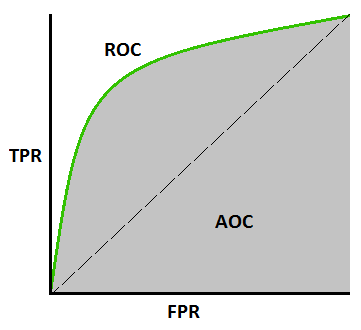
**Accuracy**: Overall, how often is the classifier correct? 

(TP+TN)/total 

**Misclassification** Rate: Overall, how often is it wrong? 

(FP+FN)/total  

equivalent to 1 minus Accuracy also known as "Error Rate" 

True Positive Rate: When it's actually yes, how often does it predict yes? 

TP/TP+ FN   also known as "Sensitivity" or "Recall" 

False Positive Rate: When it's actually no, how often does it predict yes? 

FP/TN+ FP  

 
**
Area Under Curve **

Area Under Curve(AUC) is one of the most widely used metrics for evaluation. It is used for binary classification problem. AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example. Before defining AUC, let us understand two basic terms : 

True Positive Rate (Sensitivity) : True Positive Rate is defined as TP/ (FN+TP). True Positive Rate corresponds to the proportion of positive data points that are correctly considered as positive, with respect to all positive data points. 

 

False Positive Rate (Specificity) : False Positive Rate is defined as FP / (FP+TN). False Positive Rate corresponds to the proportion of negative data points that are mistakenly considered as positive, with respect to all negative data points. 

 

False Positive Rate and True Positive Rate both have values in the range [0, 1].. AUC is the area under the curve of plot False Positive Rate vs True Positive Rate at different points in [0, 1]. 

Area under ROC curve is often used as a measure of quality of the classification models. A random classifier has an area under the curve of 0.5, while AUC for a perfect classifier is equal to 1. In practice, most of the classification models have an AUC between 0.5 and 1 

 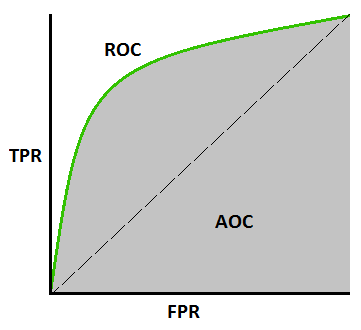

As evident, AUC has a range of [0, 1]. The greater the value, the better is the performance of our model. 

 

When a classifier cannot distinguish between the two groups, the area will be equal to 0.5 (the ROC curve will coincide with the diagonal). When there is a perfect separation of the two groups, i.e., no overlapping of the distributions, the area under the ROC curve reaches to 1 (the ROC curve will reach the upper left corner of the pl 



In [ ]:
def classification_Parameters(y_test, y_pred):
    from sklearn.metrics import confusion_matrix 
    from sklearn.metrics import accuracy_score 
    from sklearn.metrics import classification_report 
    results = confusion_matrix(y_test, y_pred) 
    print ("Confusion Matrix :")
    print(results) 
    print ('Accuracy Score :',accuracy_score(y_test, y_pred))
    print ('Report : ')
    print (classification_report(y_test, y_pred)) 

In [ ]:
classification_Parameters(y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def RocCurve(model):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [ ]:
RocCurve(randomForestCLassifier)

### Hyper parameter Tuning of Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
#Let us see what default parameters our model used
print('Default Parameters of :\n')
pprint(randomForestCLassifier.get_params())

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 100],
    'max_features': [3, 5],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [7, 10],
    'n_estimators': [200, 400]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
#Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
optimizedRandom=RandomForestClassifier(n_estimators=200,max_depth=100, min_samples_split=10, min_samples_leaf=4, max_features=5,bootstrap=True)
optimizedRandom.fit(X_train,y_train)
y_pred = optimizedRandom.predict(X_test)  
classification_Parameters(y_test, y_pred)

In [ ]:
RocCurve(optimizedRandom)

## Boosting based tree algorithm

Gradient boosting is one of the most powerful techniques for building predictive models.
How Gradient Boosting Works
**Gradient boosting involves three elements:**
- A loss function to be optimized.
- A weak learner to make predictions.
- An additive model to add weak learners to minimize the loss function.

Gradient Boosting gets its name from Gradient Descent. Given the predetermined loss function, Gradient Descent is utilized to find the parameters which minimize this loss function. Initially, gradient descent uses some parameters to looks at each point along the loss function, and find the negative derivative of that point. As gradient descent continues along the loss function, it continuously tunes the parameters until the minimum point is found. The goal is to find the optimal parameters which have the biggest decrease on the loss function. This is how Gradient Boosting attempts to minimize error. By sequentially minimizing our loss function (meaning we are sequentially minimizing the amount of error with each weak learner), our model gets stronger and stronger until a final predictor is found.

**XGBoosting**
In the realm of data science, machine learning algorithms, and model building, the ultimate goal is to build the strongest predictive model while accounting for computational efficiency as well. This is where XGBoosting comes into play. XGBoost (eXtreme Gradient Boosting) is a direct application of Gradient Boosting for decision trees. There are a myriad of resources that dive into the mathematical backing and systematic functions of XGBoost, but the main advantages are as follows:

1. Easy to use
2. Computational efficiency
3. Model Accuracy
4. Feasibility — easy to tune parameters and modify objectives.

#### Implementation of XGboost

In [ ]:
from xgboost import XGBClassifier


In [ ]:
boostClassModel= XGBClassifier()
boostClassModel.fit(X_train, y_train)

In [ ]:
y_pred = boostClassModel.predict(X_test) 
classification_Parameters(y_test, y_pred)

In [ ]:
RocCurve(boostClassModel)

### Hyper Parameters tuning of XGB classifier

Parameters of XGB Classifier

**[Tuning Parameters](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)**

General Approach for Parameter Tuning
We will use an approach similar to that of GBM here. The various steps to be performed are:

1. Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
2. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
3.Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
4. Lower the learning rate and decide the optimal parameters .

In [ ]:
#Check Default parameters
boostClassModel.get_params

In [ ]:
learning_rates = [0.5, 0.75, 1]
n_estimators=[20,30,40]
max_depths=[2,3,4]
max_features=[2,3,4]
for i in range(3):
    xgb = XGBClassifier(n_estimators=n_estimators[i], learning_rate = learning_rates[i], max_features=max_features[i], max_depth = max_depths[i], random_state = 0)
    xgb.fit(X_train, y_train)
    print("Accuracy score (training): {0:.3f}".format(xgb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(xgb.score(X_test, y_test)))
    print()

In [ ]:
#So best is 
#learning_rates = 1
#n_estimators=40
#max_depths=4
#max_features=4
xgb_optimized = XGBClassifier(n_estimators=40, learning_rate = 1, max_features=4, max_depth = 4, random_state = 0)
xgb_optimized.fit(X_train,y_train)

In [ ]:
y_pred = xgb_optimized.predict(X_test)  
classification_Parameters(y_test, y_pred)

In [ ]:
RocCurve(xgb_optimized)

# Part B - Classification with Logistic Regression
Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.
The activation function that is used is known as the sigmoid function. The plot of the sigmoid function looks like
![alt](https://cdn-images-1.medium.com/max/1200/1*yKvimZ3MCAX-rwMX2n87nw.png)
We can see that the value of the sigmoid function always lies between 0 and 1. The value is exactly 0.5 at X=0. We can use 0.5 as the probability threshold to determine the classes. If the probability is greater than 0.5, we classify it as Class-1(Y=1) or else as Class-0(Y=0).

In [ ]:
from sklearn.linear_model import LogisticRegression
LRclassifier= LogisticRegression()
LRclassifier.fit(X_train,y_train)
y_pred = LRclassifier.predict(X_test)

In [ ]:
classification_Parameters(y_test, y_pred)

In [ ]:
RocCurve(LRclassifier)

## Comparison of Different Classification Models

## AUC for models
1. Random Forest:
    - AUC: 0.95
2. XGBClassifier(Optimized) 
    - AUC: 0.94
3. Logistic regression 
    - AUC: 0.80
 
 So as per evaluation criteria **Random forest** works best for thus classification problem
    

# Regression
Evaluation Criteria
![](https://i.stack.imgur.com/83BUy.png)

In [ ]:
def regessionEvaluation(y_test, y_pred):  
    from sklearn import metrics  
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# Part C - Regression with Trees

A regression tree is built through a process known as binary recursive partitioning, which is an iterative process that splits the data into partitions or branches, and then continues splitting each partition into smaller groups as the method moves up each branch.

Initially, all records in the Training Set (pre-classified records that are used to determine the structure of the tree) are grouped into the same partition. The algorithm then begins allocating the data into the first two partitions or branches, using every possible binary split on every field. The algorithm selects the split that minimizes the sum of the squared deviations from the mean in the two separate partitions. This splitting rule is then applied to each of the new branches. This process continues until each node reaches a user-specified minimum node size and becomes a terminal node. (If the sum of squared deviations from the mean in a node is zero, then that node is considered a terminal node even if it has not reached the minimum size.)

In [ ]:
data_regression=dataSet

In [ ]:
y= data_regression['Sales']
dataX= data_regression.drop(['Sales'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(dataX,Y, test_size=0.2, random_state=0) 

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor  
modelRegrRF = RandomForestRegressor()  
modelRegrRF.fit(X_train, y_train)  

In [ ]:
y_pred = modelRegrRF.predict(X_test) 

In [ ]:
regessionEvaluation(y_test,y_pred)

### Hyper parameter tuning of Random forest regressor

In [ ]:
#Let us see what default parameters our model used
print('Parameters currently in use:\n')
pprint(modelRegrRF.get_params())

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]
}
# Create a based model
randomRegressor = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = randomRegressor, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
#grid_search.best_params_

In [ ]:
randomForestOptimized=RandomForestRegressor(n_estimators=200,max_depth=100, min_samples_split=10, min_samples_leaf=4, max_features=5,bootstrap=True)

In [ ]:
randomForestOptimized.fit(X_train,y_train)
y_pred = randomForestOptimized.predict(X_test)

In [ ]:
regessionEvaluation(y_test,y_pred)

## Boosting

### XGBoosting

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgBoostRegressor = XGBRegressor()
xgBoostRegressor.fit(X_train, y_train)

In [ ]:
y_pred = xgBoostRegressor.predict(X_test) 
regessionEvaluation(y_test,y_pred)

In [ ]:
learning_rates = [0.5, 0.75, 1]
n_estimators=[20,30,40]
max_depths=[2,3,4]
max_features=[2,3,4]
for i in range(3):
    xgb = XGBRegressor(n_estimators=n_estimators[i], learning_rate = learning_rates[i], max_features=max_features[i], max_depth = max_depths[i], random_state = 0)
    xgb.fit(X_train, y_train)
    print("Accuracy score (training): {0:.3f}".format(xgb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(xgb.score(X_test, y_test)))
    print()

In [ ]:
#So best is 
#learning_rates = 1
#n_estimators=40
#max_depths=4
#max_features=4
xgbRegressor_optimized = XGBRegressor(n_estimators=40, learning_rate = 1, max_features=4, max_depth = 4, random_state = 0)
xgbRegressor_optimized.fit(X_train,y_train)

In [ ]:
y_pred = xgbRegressor_optimized.predict(X_test) 
regessionEvaluation(y_test,y_pred)

    # Comparison of Different Regression Models

Algorithms with there metrics value:

**Linear Regression**
    - Cross Validation Error: 1.242288014816511

**Random Forest**
    - Mean Absolute Error: 405.7327874520134
    - Mean Squared Error: 435275.179031254
    - Root Mean Squared Error: 659.7538776174446

**Boosting:**
    - Mean Absolute Error: 597.3932168285128
    - Mean Squared Error: 715220.9126263337
    - Root Mean Squared Error: 845.7073445503082
   
 